# **INIT (RUN FIRST)**

In [1]:
import pandas as pd
import numpy as np
from brainflow.board_shim import BoardShim, BrainFlowInputParams, LogLevels, BoardIds
from brainflow.data_filter import DataFilter, FilterTypes
import matplotlib
import os
import torch
import pytorch_lightning as pl
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from pytorch_lightning.loggers import WandbLogger

import cv2
from torch.utils.data import DataLoader
import wandb

matplotlib.use('Agg')
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
%matplotlib inline
scaler = StandardScaler()

In [2]:
wandb.login()
api_key = 'a45abb01f9556b57620ce77c8984452bee7a8772'
board_id = 38
sf = 256

wandb: Currently logged in as: nickhartono. Use `wandb login --relogin` to force relogin


# **DATASET AND LOADER**

In [3]:
#INI DARI GAMBAR SPECTROGRAM
class AutoencoderSpectrogramImage(Dataset):
    def __init__(self, annotations_file, dir, transform=None):
        self.file_lists = pd.read_csv(annotations_file, header=None)
        self.dir = dir
        self.transform = transform
        self.eeg_names = ['Fp1', 'Fp2']

    def __len__(self):
        return len(self.file_lists)

    def __getitem__(self, idx):
        file_path = os.path.join(self.dir, self.file_lists.iloc[idx, 0].replace('/','\\'))
        file_path = file_path[:-4] + '\\'
        
        spectrograms = []
        for i in self.eeg_names:
          temp = cv2.imread(file_path + i + '.png', cv2.IMREAD_GRAYSCALE)
          spectrograms.append(temp)
        spectrograms = np.array(spectrograms)

        if self.transform:
            spectrograms = self.transform(spectrograms)
            spectrograms = spectrograms.permute(1,2,0)
        return spectrograms

In [4]:
dataset_dir = 'D:\\Nicko\\TUGAS_AKHIR\\Dataset_new_12\\Dataset_TA\\'
spectrogram_dir = 'D:\\Nicko\\TUGAS_AKHIR\\Dataset_new_12\\Dataset_TA_img\\'
training_file = dataset_dir + 'training_dir.csv'
testing_file = dataset_dir + 'testing_dir.csv'

In [5]:
#buat image
datasetTrain = AutoencoderSpectrogramImage(
    annotations_file=training_file,
    dir=spectrogram_dir,
    transform=ToTensor()
)
datasetTest = AutoencoderSpectrogramImage(
    annotations_file=testing_file,
    dir=spectrogram_dir,
    transform=ToTensor()
)

In [6]:
test = len(datasetTrain)

In [7]:
test

350

In [8]:
# split train to train and validation
# use 20% of training data for validation
train_set_size = int(len(datasetTrain) * 0.8)
valid_set_size = len(datasetTrain) - train_set_size

# split the train set into two
seed = torch.Generator().manual_seed(42)
train_set, valid_set = torch.utils.data.random_split(datasetTrain, [train_set_size, valid_set_size], generator=seed)

# data loader
train_dataloader = DataLoader(train_set, batch_size=25, shuffle=True)
validation_dataloader = DataLoader(valid_set, batch_size=25)
test_dataloader = DataLoader(datasetTest, batch_size=25)

# **AUTOENCODER MODEL**

In [9]:
#MODEL 7, 10240 param 1 Dimension
class LitAutoEncoder7(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(2, 8, 3, stride=2, padding=1),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 16, 3, stride=2, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(16, 32, 3, stride=2, padding=0),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(32, 32, 3, stride=1, padding=0),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(32),
            torch.nn.Conv2d(32, 32, 3, stride=2, padding=1),
            torch.nn.Flatten(),
            torch.nn.ReLU(True),
            torch.nn.Linear(16320, 10240)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(10240, 16320),
            torch.nn.ReLU(True),
            torch.nn.Unflatten(1, torch.Size([32,10,51])),
            torch.nn.ConvTranspose2d(32, 32, 3, stride=2,
            padding=1, output_padding=1),
            torch.nn.BatchNorm2d(32),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(32, 32, 3, stride=1,
            padding=0, output_padding=0),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(32, 16, 3, stride=2,
            padding=0, output_padding=0),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(16),
            torch.nn.ConvTranspose2d(16, 8, 3, stride=2,
            padding=1, output_padding=1),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(8, 2, 3, stride=2,
            padding=1, output_padding=1)
        )

    def forward(self, x):
      embedding = self.encoder(x)
      return embedding

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x = batch
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = torch.nn.functional.mse_loss(x_hat, x)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss, logger=True, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x = val_batch
        z = self.encoder(x)
        x_hat = self.decoder(z)
        val_loss = torch.nn.functional.mse_loss(x_hat, x)
        self.log("val_loss", val_loss, logger=True, on_epoch=True)

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x = batch
        z = self.encoder(x)
        x_hat = self.decoder(z)
        test_loss = torch.nn.functional.mse_loss(x_hat, x)
        self.log("test_loss", test_loss, logger=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [10]:
#MODEL 8, 4080 param 1 Dimension
class LitAutoEncoder8(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(2, 8, 3, stride=2, padding=1),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(8, 16, 3, stride=2, padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(16, 16, 3, stride=2, padding=0),
            torch.nn.ReLU(True),
            torch.nn.Conv2d(16, 16, 3, stride=1, padding=0),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(16),
            torch.nn.Conv2d(16, 16, 3, stride=2, padding=1),
            torch.nn.Flatten(),
            torch.nn.ReLU(True),
            torch.nn.Linear(8160, 4080)
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(4080, 8160),
            torch.nn.ReLU(True),
            torch.nn.Unflatten(1, torch.Size([16,10,51])),
            torch.nn.ConvTranspose2d(16, 16, 3, stride=2,
            padding=1, output_padding=1),
            torch.nn.BatchNorm2d(16),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(16, 16, 3, stride=1,
            padding=0, output_padding=0),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(16, 16, 3, stride=2,
            padding=0, output_padding=0),
            torch.nn.ReLU(True),
            torch.nn.BatchNorm2d(16),
            torch.nn.ConvTranspose2d(16, 8, 3, stride=2,
            padding=1, output_padding=1),
            torch.nn.BatchNorm2d(8),
            torch.nn.ReLU(True),
            torch.nn.ConvTranspose2d(8, 2, 3, stride=2,
            padding=1, output_padding=1)
        )

    def forward(self, x):
      embedding = self.encoder(x)
      return embedding

    def training_step(self, batch, batch_idx):
        # training_step defines the train loop.
        # it is independent of forward
        x = batch
        z = self.encoder(x)
        x_hat = self.decoder(z)
        loss = torch.nn.functional.mse_loss(x_hat, x)
        # Logging to TensorBoard (if installed) by default
        self.log("train_loss", loss, logger=True, on_epoch=True)
        return loss

    def validation_step(self, val_batch, batch_idx):
        x = val_batch
        z = self.encoder(x)
        x_hat = self.decoder(z)
        val_loss = torch.nn.functional.mse_loss(x_hat, x)
        self.log("val_loss", val_loss, logger=True, on_epoch=True)

    def test_step(self, batch, batch_idx):
        # this is the test loop
        x = batch
        z = self.encoder(x)
        x_hat = self.decoder(z)
        test_loss = torch.nn.functional.mse_loss(x_hat, x)
        self.log("test_loss", test_loss, logger=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        return optimizer

In [ ]:
autoencoder = LitAutoEncoder8()
autoencoder

In [ ]:
wandb_logger = WandbLogger(project='autoencoder', save_dir='E:\\Nicko\\TUGAS_AKHIR\\Autoencoder\\model_7_2_channel_1_dimension')

In [ ]:
checkpoint_callback = pl.callbacks.ModelCheckpoint(monitor="val_loss", dirpath="E:\\Nicko\\TUGAS_AKHIR\\Autoencoder\\model_7_2_channel_1_dimension\\autoencoder\\run_3",
    filename="classifier-{epoch:02d}-{val_loss:.2f}",)

In [ ]:
trainer = pl.Trainer(max_epochs=5000, devices=1, accelerator='gpu', log_every_n_steps=9, logger=wandb_logger, callbacks=[checkpoint_callback])
trainer.fit(autoencoder, train_dataloader, validation_dataloader)

In [11]:
autoencoder_load = LitAutoEncoder8().load_from_checkpoint('E:\\Nicko\\TUGAS_AKHIR\\Autoencoder\\model_7_2_channel_1_dimension\\autoencoder\\run_3\\classifier-epoch=707-val_loss=0.01.ckpt')

In [12]:
trainer = pl.Trainer(max_epochs=5000, devices=1, accelerator='gpu', log_every_n_steps=9, logger=False)
trainer.test(autoencoder_load, test_dataloader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
D:\Nicko\TUGAS_AKHIR\TA_env\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, test_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 6 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

D:\Nicko\TUGAS_AKHIR\TA_env\lib\site-packages\pytorch_lightning\core\module.py:481: UserWarning: You called `self.log('test_loss', ..., logger=True)` but have no logger configured. You can enable one by doing `Trainer(logger=ALogger(...))`
  rank_zero_warn(


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.008454510010778904
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.008454510010778904}]

In [13]:
data_test = datasetTest[0]

In [14]:
data_test = data_test[None, :]

In [15]:
data_test.shape

torch.Size([1, 2, 180, 836])

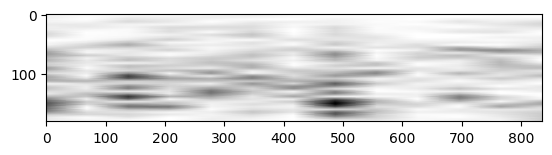

In [16]:
data_squeezed = torch.squeeze(data_test)
plt.imshow(data_squeezed[0].numpy(), cmap='gray_r')

In [17]:
autoencoder_load.eval()
with torch.no_grad():
    result = autoencoder_load(data_test)
    decoded_result = autoencoder_load.decoder(result)
    print(decoded_result.shape)

torch.Size([1, 2, 180, 836])


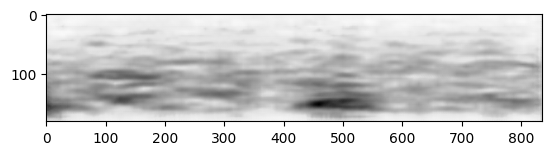

In [18]:
decoded_squeezed = torch.squeeze(decoded_result)
plt.imshow(decoded_squeezed[0].detach().numpy(), cmap='gray_r')